In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import shapely.geometry as sgeom
import seaborn as sns
import pandas as pd
from dask.distributed import Client, LocalCluster, get_task_stream
import xarray as xr
import glob
from aostools.climate import PlotEPfluxArrows#, set_size
import matplotlib.patches as mpatches
import matplotlib.path as mpath

# Constants

In [5]:
#sns.set_style('whitegrid')
#plt.style.use(['seaborn-whitegrid','seaborn-poster','plotstyle.mplstyle'])
mpl.rcParams.update({'font.size': 18})
xr.set_options(keep_attrs=True,display_style='html')

In [6]:
timescale = 20
DJF_bool = '_DJFonly'
root_path = '/mnt/nas4.meop2/meop40.data.model/CMAM/0A.daily/'
root_path = '/mnt/data04/model/CMAM/0A.daily/'
cesta = f'{root_path}composites_woSSW{DJF_bool}/'
name = 'himalayas'
lag = 0
a0 = 6376.0e3 # [m]
g = 9.81 #[m/s2 ]

# Functions

In [7]:
def cosphi(lat):
    return np.cos(np.deg2rad(lat))

# Load data

In [8]:
timescale = 20
num_waves = 3
wave_range = list(range(1,num_waves+1))#+['45678']
e_type_ls = ['himalayas']#, 'eastasia', 'westamer']
titles = ['Himalayas']#, 'East Asia', 'Rocky Mountains'] #'West America']
noe = [37,37,25]
var_ls= ['acceldiv-calc','ep_p','ep_phi']#,'acceldiv-calc_wn','ep_phi-wn','ep_p-wn','accelogw']#, 'accelogw'] #'ua'
what = 'anomalies'
inserted_wave = 0#'all'

ds_ls = []
for var in var_ls:
    da_ls = []
    for i,e_type in enumerate(e_type_ls):
        if var == 'accelogw':
            infile = f'{cesta}{var}_{what}_comp_{e_type}_{timescale}days.nc'
            print(infile)
            da_wave = xr.open_dataarray(infile)
            da_wave['plev'] = da_wave.plev/100.
            da_wave['plev'].attrs['units'] = 'hPa'
            #print(da)
        elif var == 'ep_p':
            infile = f'{cesta}{var}_{what}_comp_{e_type}_{timescale}days.nc'
            print(infile)
            da_wave = xr.open_dataarray(infile)*-10000
            da_wave = da_wave.expand_dims('wave')
            da_wave.name = var+'-wn1'
            da_wave['wave'] = [inserted_wave]#'all']
            
        elif var == 'ep_phi':
            infile = f'{cesta}{var}_{what}_comp_{e_type}_{timescale}days.nc'
            print(infile)
            da_wave = xr.open_dataarray(infile)
            da_wave = da_wave.expand_dims('wave')
            da_wave.name = var+'-wn1'
            da_wave['wave'] = [inserted_wave]#'al
        
        elif var == 'acceldiv-calc':
            infile = f'{cesta}{var}_{what}_comp_{e_type}_{timescale}days.nc'
            print(infile)
            da_wave = xr.open_dataarray(infile)
            da_wave = da_wave.expand_dims('wave')
            da_wave['plev'] = da_wave.plev/100.
            da_wave['plev'].attrs['units'] = 'hPa'
            da_wave.name = var+'_wn1'
            da_wave['wave'] = [inserted_wave]#'all']
            
        else:
            da_wave_ls = []
            for i in wave_range:
                infile = f'{cesta}{var}{i}_{what}_comp_{e_type}_{timescale}days.nc'
                print(infile)
                da = xr.open_dataarray(infile)
                #da['wave'] = ['#'+str(i)]
                #da = da.squeeze()
                da = da.reset_coords(drop=True)
                if i == '45678':
                    da = da.expand_dims('wave')
                    da['wave'] = [i]
                    
                #da['plev'] = da.plev/100.
                da_wave_ls.append(da)
                
            da_wave = xr.concat(da_wave_ls, dim = 'wave')                
            #print(da)#.data_vars.keys()[0])
        
            #print(da_wave)
        da_ls.append(da_wave)
    da_conc = xr.concat(da_ls, dim = 'e_type')
    da_conc['e_type'] = e_type_ls 
    ds_ls.append(da_conc)
    
ds_all = xr.merge(ds_ls).squeeze().reset_coords(drop = True)#, compat='override')
ds_all

/mnt/data04/model/CMAM/0A.daily/composites_woSSW_DJFonly/acceldiv-calc_anomalies_comp_himalayas_20days.nc
/mnt/data04/model/CMAM/0A.daily/composites_woSSW_DJFonly/ep_p_anomalies_comp_himalayas_20days.nc
/mnt/data04/model/CMAM/0A.daily/composites_woSSW_DJFonly/ep_phi_anomalies_comp_himalayas_20days.nc


<xarray.Dataset>
Dimensions:            (lag: 21, lat: 48, plev: 63)
Coordinates:
  * plev               (plev) float64 1e+03 925.0 850.0 ... 0.0015 0.001 0.0007
  * lat                (lat) float64 -87.16 -83.48 -79.78 ... 79.78 83.48 87.16
  * lag                (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 ... 3 4 5 6 7 8 9 10
Data variables:
    acceldiv-calc_wn1  (lag, plev, lat) float64 0.2569 3.677 ... -0.4105 -2.483
    ep_p-wn1           (lag, plev, lat) float64 -11.24 -44.84 ... -0.0001523
    ep_phi-wn1         (lag, plev, lat) float64 0.1493 0.383 ... -3.656 8.949

In [9]:
infile_name = f'{cesta}ptrop_absolute_comp_*_{timescale}days.nc'
infiles = glob.glob(infile_name)
#print(infiles)
e_types = list(map(lambda x: x.split('comp_')[1].split('_{}days'.format(timescale))[0], infiles))
da_trop =  xr.open_mfdataset(infiles, concat_dim='e_type', combine = 'nested')
da_trop['e_type'] = e_types
da_trop['ptrop'] = da_trop.ptrop/100.
da_trop

<xarray.Dataset>
Dimensions:  (e_type: 3, lag: 21, lat: 48, lon: 96)
Coordinates:
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * lag      (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10
  * e_type   (e_type) <U9 'himalayas' 'eastasia' 'westamer'
Data variables:
    ptrop    (e_type, lag, lat, lon) float64 dask.array<chunksize=(1, 21, 48, 96), meta=np.ndarray>

# Calculation

In [10]:
vert_const = a0
#vert_const = 2*np.pi*a0/g
lat_slice = slice(50,70)
pres_slice = slice(70,10)
lag = 0

def integrate_fluxes(ds_all, lat_slice, pres_slice, vert_const = a0):

    cosphi_arr = cosphi(ds_all.sel(lat = lat_slice).lat)
    influx_vert  = (
        (
            ds_all['ep_p-wn1']
            .sel(lag = lag, plev = pres_slice.start, lat = lat_slice)
            *cosphi_arr
        )
        .assign_coords(lat = cosphi_arr)
        .integrate('lat')
        #*vert_const#*a0
    )

    outflux_vert = (
        (
            ds_all['ep_p-wn1']
            .sel(lag = lag, plev = pres_slice.stop, lat = lat_slice)
            *cosphi_arr
        )
        .assign_coords(lat = cosphi_arr)
        .integrate('lat')
        #*vert_const#*a0
    )

    sel_lat_dict = dict(lat = lat_slice.stop, method = 'nearest')
    cosphi_arr = cosphi(ds_all.sel(**sel_lat_dict).lat)
    influx_hor = (
        ds_all['ep_phi-wn1']
        .sel(lag = lag, plev = pres_slice)
        .sel(**sel_lat_dict)
        .integrate('plev')
        *cosphi_arr/vert_const

    )

    sel_lat_dict = dict(lat = lat_slice.start, method = 'nearest')
    cosphi_arr = cosphi(ds_all.sel(**sel_lat_dict).lat)
    outflux_hor = (
        ds_all['ep_phi-wn1']
        .sel(lag = lag, plev = pres_slice)
        .sel(**sel_lat_dict)
        .integrate('plev')
        *cosphi_arr/vert_const
    )
    
    #total_div = outflux_hor - influx_hor +  influx_vert/1e4 - outflux_vert/1e4#.load()
    total_div = outflux_hor - influx_hor +  influx_vert- outflux_vert#.load()
    print(f'outflux_hor {outflux_hor.values} - influx_hor {influx_hor.values} + influx_vert {influx_vert.values} - outflux_vert {outflux_vert.values}')
    print(f'total_div {total_div.values}')
    return influx_vert, outflux_vert, influx_hor, outflux_hor, total_div

def concat_fluxes(ds_all, lat_slice, pres_slice):
    influx_vert, outflux_vert, influx_hor, outflux_hor, total_div = integrate_fluxes(ds_all, lat_slice, pres_slice)
                                 
    ds_q_ver = xr.concat([influx_vert,outflux_vert], dim = 'plev')
    ds_q_ver = ds_q_ver.expand_dims('lat')
    ds_q_ver['lat'] = [(lat_slice.stop+lat_slice.start)/2]
    ds_q_ver.name = 'vertical'

    ds_q_hor = xr.concat([influx_hor,outflux_hor], dim = 'lat')
    ds_q_hor = ds_q_hor.expand_dims('plev')
    ds_q_hor['plev'] = [(pres_slice.start+pres_slice.stop)/2]
    ds_q_hor.name = 'horizontal'

    #norm = np.sqrt(ds_q_hor**2+ds_q_ver**2)
    scaling_hor = -1#*norm# because of negative `dp`  np.abs(ds_q_hor.mean())
    scaling_ver = -1#*norm# because of negative `Fp` np.abs(ds_q_ver.mean())
    ds_q_pert = xr.merge([ds_q_hor/scaling_hor, 
                          ds_q_ver/scaling_ver])
    #print(ds_q_pert.mean())
    ds_q_pert = ds_q_pert.fillna(0)
    norm = np.hypot(ds_q_pert['horizontal'],ds_q_pert['vertical'])
    ds_q_pert = ds_q_pert/norm
    
    return ds_q_pert, ds_q_ver, ds_q_hor, total_div


In [11]:
lat_slice = slice(50,70)
pres_slice= slice(70,10)
ds_q_pert, ds_q_ver, ds_q_hor, total_div = concat_fluxes(ds_all, 
                                                         lat_slice,
                                                         pres_slice)

outflux_hor 1.236930065689078e-05 - influx_hor -1.1521853380991632e-05 + influx_vert -1.127379122966249 - outflux_vert -0.04628523193572163
total_div -1.0810699998764897


In [12]:
lat_slice = slice(50,70)
pres_slice= slice(70,10)
ds_q_pert, ds_q_ver, ds_q_hor, total_div = concat_fluxes(ds_all, 
                                                         lat_slice,
                                                         pres_slice)

outflux_hor 1.236930065689078e-05 - influx_hor -1.1521853380991632e-05 + influx_vert -1.127379122966249 - outflux_vert -0.04628523193572163
total_div -1.0810699998764897


In [13]:
lat_slice = slice(50,70)
pres_slice= slice(70,10)
ds_q_pert, ds_q_ver, ds_q_hor, total_div = concat_fluxes(ds_all, 
                                                         lat_slice,
                                                         pres_slice)

outflux_hor 1.236930065689078e-05 - influx_hor -1.1521853380991632e-05 + influx_vert -1.127379122966249 - outflux_vert -0.04628523193572163
total_div -1.0810699998764897


In [14]:
lat_slice = slice(50,70)
pres_slice= slice(70,10)
ds_q_pert, ds_q_ver, ds_q_hor, total_div = concat_fluxes(ds_all, 
                                                         lat_slice,
                                                         pres_slice)

outflux_hor 1.236930065689078e-05 - influx_hor -1.1521853380991632e-05 + influx_vert -1.127379122966249 - outflux_vert -0.04628523193572163
total_div -1.0810699998764897


In [15]:
cosphi_arr = cosphi(ds_all.sel(lat = lat_slice).lat)
conv_int = (
    ds_all['acceldiv-calc_wn1']
    .sel(lag = lag, lat = lat_slice, plev = pres_slice)
    .assign_coords(lat = cosphi_arr)
    .integrate(['lat','plev'])
    
)
conv_int

<xarray.DataArray 'acceldiv-calc_wn1' ()>
array(-15.63188833)
Coordinates:
    lag      int64 0

In [51]:
ds_q_ver.mean()

<xarray.DataArray 'vertical' ()>
array(-3741641.96342748)
Coordinates:
    lag      int64 0

In [191]:
ds_q_hor

<xarray.DataArray 'horizontal' (plev: 1, lat: 2)>
array([[-73.46333716,  78.86666099]])
Coordinates:
  * lat      (lat) float64 68.65 50.1
    lag      int64 0
  * plev     (plev) float64 40.0

In [192]:
ds_q_ver

<xarray.DataArray 'vertical' (lat: 1, plev: 2)>
array([[-7188169.2880328 ,  -295114.63882216]])
Coordinates:
  * plev     (plev) float64 70.0 10.0
    lag      int64 0
  * lat      (lat) float64 60.0

In [267]:
ds_q_hor

<xarray.DataArray 'horizontal' (plev: 1, lat: 2)>
array([[-73.46333716,  78.86666099]])
Coordinates:
  * lat      (lat) float64 68.65 50.1
    lag      int64 0
  * plev     (plev) float64 40.0

In [270]:
ds_q_ver

<xarray.DataArray 'vertical' (lat: 1, plev: 2)>
array([[-7188169.2880328 ,  -295114.63882216]])
Coordinates:
  * plev     (plev) float64 70.0 10.0
    lag      int64 0
  * lat      (lat) float64 60.0

(10.0, 90.0)

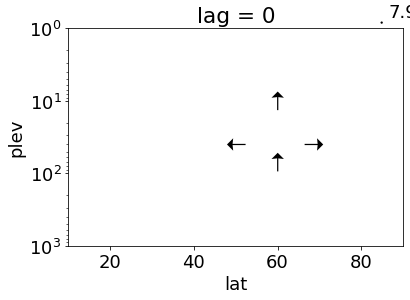

In [207]:
kwargs = dict(units ='inches', scale = 200000)
kwargs = dict(
              units='width',
              pivot='mid', headwidth= 10,
              minshaft=3          
             )
#kwargs = dict(units ='inches')
p = ds_q_pert.plot.quiver(x = 'lat', 
                          y = 'plev', 
                          u = 'horizontal', 
                          v = 'vertical',
                         **kwargs)
plt.yscale('log')
plt.ylim(1000,1)
plt.xlim(10,90)

In [108]:
root_path

'/mnt/data04/model/CMAM/0A.daily/'

In [115]:
ds_ua_clim = xr.open_dataset(f'{root_path}ua/ua_climatology.nc')
ds_ua_clim['plev'] = ds_ua_clim.plev/100.

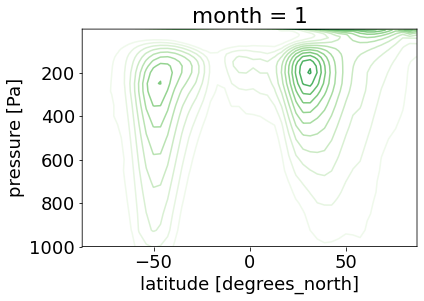

In [215]:
ds_ua_clim['ua'].where(ds_ua_clim['ua'] > 0) \
                .sel(month = 1) \
                .mean('lon').plot.contour(x = 'lat',
                                          yincrease = False, 
                                          cmap = 'Greens',
                                          levels  = 21, 
                                                         )

<ipython-input-220-b277535914db>:66: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  el = mpatches.Ellipse((70, 150), 35, 235, facecolor='None',


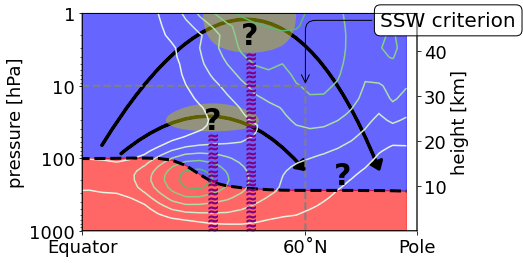

In [220]:
kwargs = dict(units ='inches', scale = 200000)
kwargs = dict(
              units='width',
              pivot='mid', headwidth= 10,
              minshaft=3          
             )
lat_start = 0
fig, ax = plt.subplots()    
da_trop2=da_trop['ptrop'].sel(e_type='himalayas', lag=0).mean('lon')
lat = da_trop2.lat.values
# tropopause line
ax.plot(lat, da_trop2, color = 'k', 
        linestyle='--', lw = 3)
# wind climatology
ds_ua_clim['ua'].where(ds_ua_clim['ua'] > 0) \
                .sel(month = 1) \
                .mean('lon').plot.contour(x = 'lat',
                                          yincrease = False, 
                                          cmap = 'Greens',
                                          levels  = 11, 
                                          ax = ax)
ax.fill_between(lat, da_trop2, color = 'blue', alpha = 0.6) # stratospheric cooling
ax.fill_between(lat, da_trop2, y2=1000, color = 'red', alpha = 0.6) # troposheric warming

ax.set_yscale('log')
ax.set_ylim(1000,1)
ax.set_xlim(lat_start,90)
ax.set_ylabel('pressure [hPa]')
#ax.set_xlabel('latitude [deg]')
ax.set_xlabel('')
ax.set_xticks([0,60,90])
ax.set_xticklabels(['Equator','60˚N','Pole'])
ax.set_title('')
fmt = mpl.ticker.FormatStrFormatter("%g")
ax.yaxis.set_major_formatter(fmt)

# BDC 
style = "Simple, tail_width=0.5, head_width=12, head_length=8"
kw = dict(arrowstyle=style, color="k", lw = 3)
a2 = patches.FancyArrowPatch((5, 70), (80, 150),
                             connectionstyle="arc3,rad=-1", **kw)
ax.add_patch(a2)
a3 = patches.FancyArrowPatch((10, 90), (60, 150),
                             connectionstyle="arc3,rad=-.5", **kw)
ax.add_patch(a3)

# SSW threshold
ax.hlines(10,lat_start,60, color = 'gray', linestyles='--', linewidths = 2)
ax.vlines(60,1000,10, color = 'gray', linestyles='--', linewidths = 2)
ax.annotate('SSW criterion',
            xy=(60, 10), xycoords='data',
            xytext=(75, 60), textcoords='offset points',
            size=20,
            bbox=dict(boxstyle="round", fc="w"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=-90,rad=10"),
            zorder = 1000)

# wave dissipation regions
wave_center1 = 35
el = mpatches.Ellipse((wave_center1, 30), 25, 25, facecolor='y', alpha=0.5)
ax.add_artist(el)
wave_center2 = 45
el = mpatches.Ellipse((wave_center2, 1), 25, 5, facecolor='y', alpha=0.5)
ax.add_artist(el)
el = mpatches.Ellipse((70, 150), 35, 235, facecolor='None', 
                      color = 'k', fill = False)
#ax.add_artist(el)

rectangle = mpatches.Rectangle((55, 100), 30, 150, edgecolor='orange',
facecolor="None", linewidth=4)
#ax.add_patch(rectangle)
rx, ry = rectangle.get_xy()
cx = rx + rectangle.get_width()/2.0
cy = ry + rectangle.get_height()/2.0

# question marks
ax.annotate("?", (cx, cy), color='black', 
            weight='bold', fontsize=30, ha='center', va='center')
ax.annotate("?", (wave_center1, 30), color='black', 
            weight='bold', fontsize=30, ha='center', va='center')
ax.annotate("?", (wave_center2, 2), color='black', 
            weight='bold', fontsize=30, ha='center', va='center')

ax_h = ax.twinx()
ax_h.get_shared_y_axes()
ax_h.axis([lat_start, 90, 7*np.log(1013.25/1000), 7*np.log(1013.25/1)])
ax_h.set_ylabel('height [km]')
ax_h.tick_params(direction='out', which='both')

# waves
color = 'purple'
style = r'$\sim$'
t = np.arange(0,22,1)
ax_h.plot([wave_center1]*t.shape[0], t, linestyle='None', 
         marker=style, color=color, markersize=10)
t = np.arange(0,40,1)
ax_h.plot([wave_center2]*t.shape[0], t, linestyle='None', 
         marker=style, color=color, markersize=10)


In [162]:
c0, c1 = el.get_extents().get_points()
x0, y0 = c0
x0, y0 = c0

In [170]:
np.sum([(x/2, y/2) for x,y in zip(c0,c1)], axis = 0)

array([ 42.5, 177.5])

outflux_hor 1.236930065689078e-05 - influx_hor -1.1521853380991632e-05 + influx_vert -1.127379122966249 - outflux_vert -0.04628523193572163
total_div -1.0810699998764897
outflux_hor 0.00024121876318439463 - influx_hor -3.539032182321483e-05 + influx_vert -3.186412205894702 - outflux_vert -1.5864079931130766
total_div -1.5997276036966177


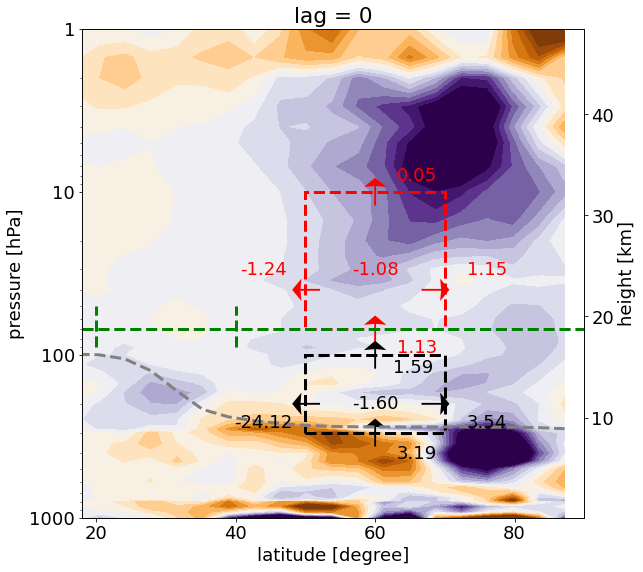

In [18]:
fig, ax = plt.subplots(figsize = (9,9))
lat_start = 18#-20

cmap = mpl.cm.PuOr_r#RdBu_r
levels = np.arange(-7.2,7.6,0.4)
plot_kwargs = dict(yincrease = False, add_colorbar=False, 
                   cmap = cmap, robust = True,
                   levels = 21)
temp = ds_all['acceldiv-calc_wn1'].sel(lag = 0, plev = slice(None,1))
temp.plot.contourf(x = 'lat', **plot_kwargs)

da_trop2=da_trop['ptrop'].sel(e_type=e_type, lag=0).mean('lon')
lat = da_trop2.lat.values
ax.plot(lat, da_trop2, color = 'gray', 
        linestyle='--', lw = 3)

ax.set_yscale('log')
ax.hlines(70,lat_start,90, color = 'green', linestyles='--', linewidths = 3)
box = sgeom.box(minx=70, maxx=102.5, miny=20, maxy=40)
ax.vlines(list(box.bounds)[1::2],90,50, color = 'green', linestyles='--', linewidths = 3)

color = 'red'
kwargs = dict(scale_units='y', pivot='mid',
              headwidth= 12, 
              minshaft=3, color = color)#, scale = 10000)
kwargs = dict(units='width', pivot='mid',
              headwidth= 12, minlength = 2,
              minshaft=3, color = color)

# upper box
lat_slice = slice(50,70)
pres_slice= slice(70,10)
ds_q_pert, ds_q_ver, ds_q_hor, total_div = concat_fluxes(ds_all, 
                                                         lat_slice,
                                                         pres_slice)
ds_q_pert.plot.quiver(x = 'lat', 
                          y = 'plev', 
                          u = 'horizontal', 
                          v = 'vertical',
                          ax = ax, add_guide = False,
                         **kwargs)
num = ds_q_ver.sel(plev = pres_slice.start).values[0]*-1 # /1e4
prec = 2
ax.text(66, pres_slice.start+20, f"{num:0.{prec}f}", color = color,
            ha='center', va='center')

num = ds_q_ver.sel(plev = pres_slice.stop).values[0]*-1 # /1e4
ax.text(66, pres_slice.stop-2, f"{num:0.{prec}f}", color = color,
            ha='center', va='center')

num = ds_q_hor.sel(lat = lat_slice.start, method = 'nearest').values[0]*-1e5#/1e4
ax.text(lat_slice.start-6, pres_slice.start-40, f"{num:0.{prec}f}", color = color,
            ha='center', va='center')

num = ds_q_hor.sel(plev = lat_slice.stop, method = 'nearest').values[0]*-1e5#/1e4
ax.text(lat_slice.stop+6, pres_slice.start-40, f"{num:0.{prec}f}", color = color,
            ha='center', va='center')

num = total_div.values#/1e4
ax.text(60, 30, f"{num:0.{prec}f}", color = color,
            ha='center', va='center')
lat_slice_diff = lat_slice.stop-lat_slice.start
pres_slice_diff = pres_slice.stop-pres_slice.start
rect = mpl.patches.Rectangle((lat_slice.start, pres_slice.start), 
                             lat_slice_diff, pres_slice_diff, linewidth=3, 
                             edgecolor='red', facecolor='none',
                             linestyle='--')
ax.add_patch(rect)

#lower box
pres_slice = slice(300,100)
color = 'k'
kwargs = dict(units='width', pivot='mid',
              headwidth= 12, minlength = 2,
              minshaft=3, color = color)
ds_q_pert, ds_q_ver, ds_q_hor, total_div = concat_fluxes(ds_all, 
                                                         slice(50,70),
                                                         pres_slice)
ds_q_pert.plot.quiver(x = 'lat', 
                          y = 'plev', 
                          u = 'horizontal', 
                          v = 'vertical',
                          ax = ax, add_guide = False,
                         **kwargs)
# upper and lower edges
num = ds_q_ver.sel(plev = pres_slice.start).values[0]*-1 # /1e4
prec = 2
ax.text(66, pres_slice.start+100, f"{num:0.{prec}f}", color = color ,
            ha='center', va='center')

num = ds_q_ver.sel(plev = pres_slice.stop).values[0]*-1 # /1e4
ax.text(65.5, pres_slice.stop+20, f"{num:0.{prec}f}", color = color ,
            ha='center', va='center')

# lateral edges
num = ds_q_hor.sel(lat = lat_slice.start, method = 'nearest').values[0]*-1e5#/1e4
ax.text(lat_slice.start-6, pres_slice.start-40, f"{num:0.{prec}f}", color = color ,
            ha='center', va='center')

num = ds_q_hor.sel(plev = lat_slice.stop, method = 'nearest').values[0]*-1e5#/1e4
ax.text(lat_slice.stop+6, pres_slice.start-40, f"{num:0.{prec}f}", color = color ,
            ha='center', va='center')

num = total_div.values#/1e4
ax.text(60, 200, f"{num:0.{prec}f}", color = color ,
            ha='center', va='center')


ax.axis([lat_start, 90, 1000, 1]) # 0.1
ax.set_yticks([1000,100,10,1]) # ,0.1
fmt = mpl.ticker.FormatStrFormatter("%g")
ax.yaxis.set_major_formatter(fmt)
ax.set_xticks([-20,0,20,40,60,80])
ax.set_ylabel('pressure [hPa]')
ax.set_xlabel('latitude [degree]')
# Create a Rectangle patch
lat_slice_diff = lat_slice.stop-lat_slice.start
pres_slice_diff = pres_slice.stop-pres_slice.start
rect = mpl.patches.Rectangle((lat_slice.start, 300), 
                             lat_slice_diff, -200, linewidth=3, 
                             edgecolor='k', facecolor='none',
                             linestyle='--')

# Add the patch to the Axes
ax.add_patch(rect)

ax_h = ax.twinx()
ax_h.get_shared_y_axes()
ax_h.axis([lat_start, 90, 7*np.log(1013.25/1000), 7*np.log(1013.25/1)])
ax_h.set_ylabel('height [km]')
ax_h.tick_params(direction='out', which='both')
plt.savefig('influx_analysis_lag0.pdf', bbox_inches='tight')

In [372]:
ds_q_pert, ds_q_ver, ds_q_hor, total_div = concat_fluxes(ds_all, 
                                                         slice(50,70),
                                                         slice(500,300))

outflux_hor 0.0002262850865694671 - influx_hor -9.27216783377089e-05 + influx_vert -0.5887569797199934 - outflux_vert -3.186412205894702
total_div 2.597974232939616


In [346]:
1538.0108340637003 +225.64869194481778  -20316564.22478462/1e4 +10114937.364088977/1e4



743.4968399389537

In [332]:
-1538+225.6

-1312.4

In [333]:
1011.5-2031.7

-1020.2

In [152]:
(70-3)*-1

-67

In [150]:
pres_slice_diff

-67